In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score

snr_list = ['6_dB', '-6_dB', '0_dB']

def read_csv_files(target, pattern='anomaly_score_*.csv'):
    return glob.glob(os.path.join(target, pattern))

    
# 파일 이름에서 레이블을 결정하는 함수
def get_label(filename):
    if 'abnormal' in filename:
        return 1
    else:
        return 0

def get_labels_and_scores(csv_files):
    actual_labels = []
    anomaly_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())
    return pd.Series(actual_labels), pd.Series(anomaly_scores)



In [2]:
def get_labels_and_scores_n(csv_files):
    actual_labels = []
    anomaly_scores = []
    normal_anomaly_scores = []
    abnormal_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())

        normal_scores = df[df['label'] == 0]['anomaly_score']
        abnormal_score = df[df['label']==1]['anomaly_score']
        if not normal_scores.empty:
            normal_anomaly_scores.extend(normal_scores.tolist())
        abnormal_scores.extend(abnormal_score)
    return actual_labels, anomaly_scores, normal_anomaly_scores, abnormal_scores

1529
1529
          pred   gt
1665  0.000020  1.0
1667  0.000020  1.0
1680  0.000015  1.0
1681  0.000018  1.0
1690  0.000016  1.0
...        ...  ...
2608  0.000003  1.0
2612  0.000001  1.0
2613  0.000001  1.0
2639  0.000006  1.0
2842  0.000003  1.0

[220 rows x 2 columns]


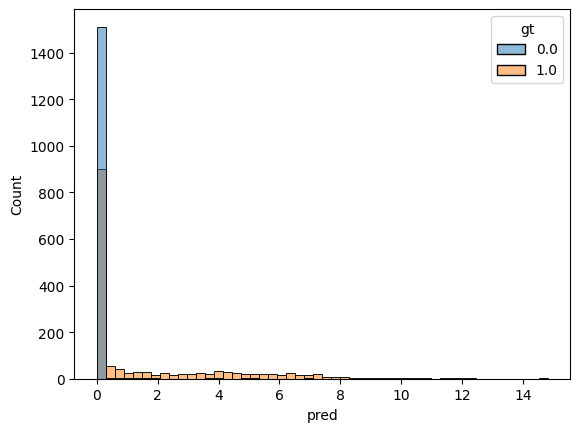

In [3]:
def draw_anomaly_score(anomaly_scores, abnormal_scores):
    anomaly_scores = np.array(anomaly_scores)
    abnormal_scores = np.array(abnormal_scores)

    # print(anomaly_scores.shape)
    # print(abnormal_scores.shape)

    normal_labels = np.zeros_like(anomaly_scores)
    abnormal_labels = np.zeros_like(abnormal_scores) + 1

    scores = np.hstack((anomaly_scores, abnormal_scores)).tolist()
    labels = np.hstack((normal_labels, abnormal_labels)).tolist()

    target_df = pd.DataFrame({"pred": scores, "gt": labels})
    # target_df = target_df[target_df["pred"] < 0.00002]
    print(target_df[(target_df["pred"] < 0.00002) & (target_df["gt"] == 1.0)])

    sns.histplot(data=target_df, hue="gt", x="pred", bins=50)

def process_anomaly_score(test=False):
    csv_files = read_csv_files('./test')
    # print(sorted(csv_files))
    actual_labels, tot, normal_anomaly_scores, abnormal_scores = get_labels_and_scores_n(csv_files)
    # print(len(tot))
    print(len(normal_anomaly_scores))
    print(len(abnormal_scores))
    auc = roc_auc_score(actual_labels, tot)
    # print(auc)
    draw_anomaly_score(normal_anomaly_scores, abnormal_scores)
    

process_anomaly_score(test=True)

In [4]:


def calculate_metrics(actual_labels, anomaly_scores):
    thresholds = np.arange(0.0, 5.0, 0.001)
    f1_scores = []
    for threshold in thresholds:
        predicted_labels = (anomaly_scores > threshold).astype(int)
        f1 = f1_score(actual_labels, predicted_labels)
        f1_scores.append(f1)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, f1, optimal_threshold



def use_o(test=False):
    # val_csv_files = read_csv_files('./')
    # val_actual_labels, val_anomaly_scores = get_labels_and_scores(val_csv_files)
    # fpr, tpr, roc_auc, optimal_threshold = calculate_threshold(val_actual_labels, val_anomaly_scores)

    test_csv_files = read_csv_files('./test')
    test_actual_labels, test_anomaly_scores = get_labels_and_scores(test_csv_files)

    predicted_labels, f1, optimal_threshold = calculate_metrics(test_actual_labels, test_anomaly_scores)
    
    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1:.04}')
    
    # draw_confusion_matrix(test_actual_labels, predicted_labels, test)

    
    # return results

use_o(test=True)


Optimal threshold: 0.001
F1 Score: 0.7765


Optimal threshold: 0.008544198
F1 Score: 0.7345


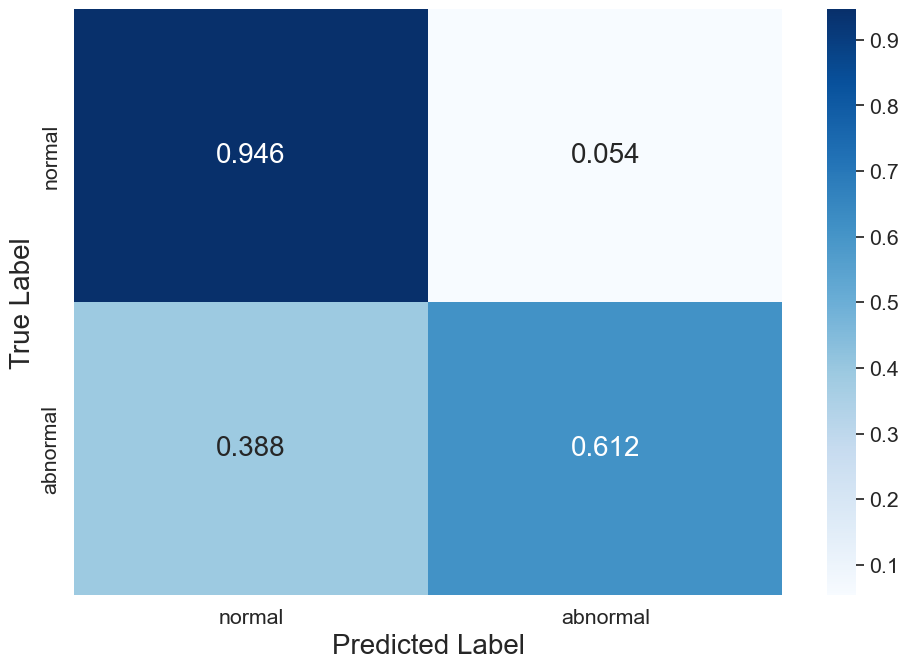

roc_auc: 0.8376683954839259


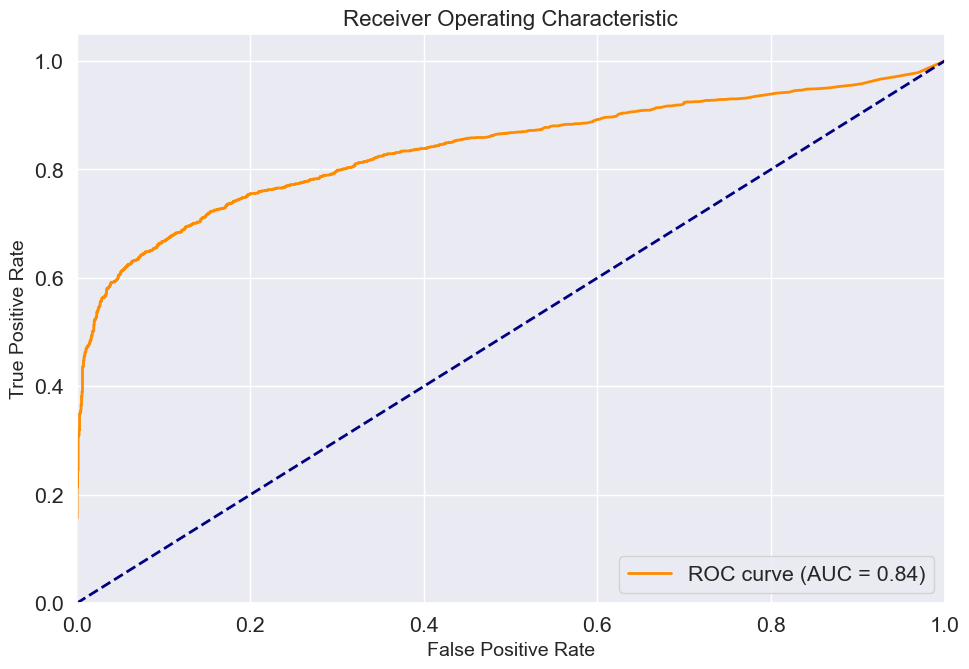

In [5]:
# def calculate_metrics(actual_labels, anomaly_scores):
#     fpr, tpr, thresholds = roc_curve(actual_labels, anomaly_scores)
#     # print(thresholds)
#     roc_auc = auc(fpr, tpr)
#     J = tpr - fpr
#     optimal_idx = np.argmax(J)
#     optimal_threshold = thresholds[optimal_idx]
#     predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
#     f1 = f1_score(actual_labels, predicted_labels)
#     return predicted_labels, fpr, tpr, optimal_idx, roc_auc, optimal_threshold, f1

def calculate_threshold(actual_labels, anomaly_scores):
    fpr, tpr, thresholds = roc_curve(actual_labels, anomaly_scores)
    # print(thresholds)
    roc_auc = auc(fpr, tpr)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]
    return fpr, tpr, roc_auc, optimal_threshold

def calculate_metrics(actual_labels, anomaly_scores, optimal_threshold):
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
    f1 = f1_score(actual_labels, predicted_labels)
    return predicted_labels, f1


def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    plt.close() 

def draw_roc_curve(fpr, tpr, roc_auc, optimal_threshold, test=False):
    plt.figure(figsize=(10, 7))
    print(f'roc_auc: {roc_auc}')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    
    plt.close() 

def use_Youden_inede(test=False):
    val_csv_files = read_csv_files('./')
    val_actual_labels, val_anomaly_scores = get_labels_and_scores(val_csv_files)
    fpr, tpr, roc_auc, optimal_threshold = calculate_threshold(val_actual_labels, val_anomaly_scores)

    test_csv_files = read_csv_files('./test')
    test_actual_labels, test_anomaly_scores = get_labels_and_scores(test_csv_files)

    predicted_labels, f1 = calculate_metrics(test_actual_labels, test_anomaly_scores, optimal_threshold)
    
    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1:.04}')
    
    draw_confusion_matrix(test_actual_labels, predicted_labels, test)
    draw_roc_curve(fpr, tpr, roc_auc, optimal_threshold, test)
    
    # return results

use_Youden_inede(test=True)

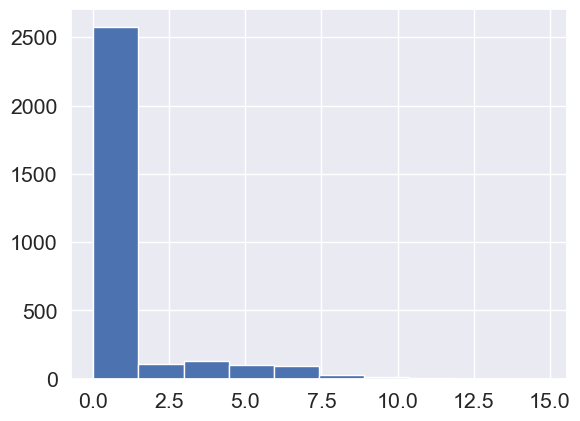

3058
Z-Score Threshold: 1
F1 Score: 0.6449


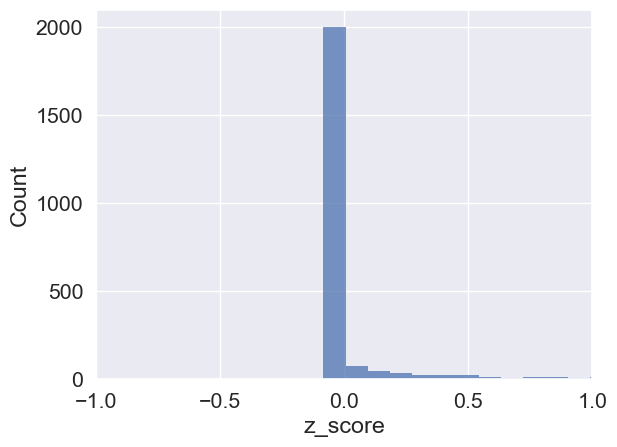

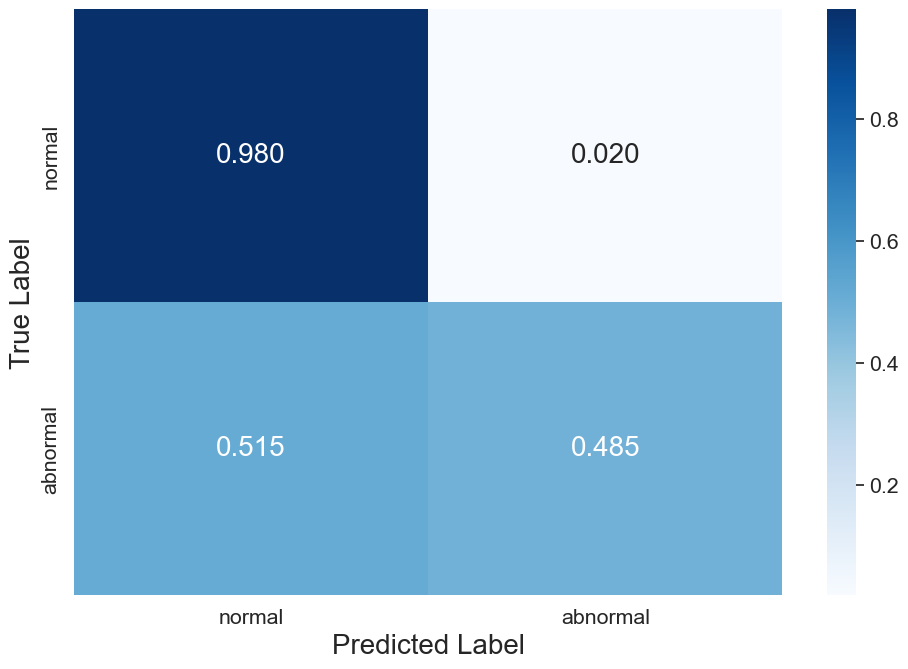

In [6]:
def read_csv_files(target, pattern='anomaly_score_*.csv'):
    return glob.glob(os.path.join(target, pattern))
    

def calculate_metrics_zscore(actual_labels, normal_anomaly_scores, anomaly_scores, z_threshold=1):
    plt.hist(anomaly_scores)
    plt.show()
    abnormal_scores = np.array(normal_anomaly_scores)
    normal_labels = np.zeros_like(normal_anomaly_scores)

    scores = np.hstack(abnormal_scores).tolist()
    labels = np.hstack(normal_labels).tolist()
    # print(len(scores))
    # print(len(labels))
   

    normal_mean = np.mean(scores)
    # print(normal_mean)
    normal_std = np.std(scores)
    # print(normal_std)
    # plt.hist(anomaly_scores)
    # plt.show()
    # Z-Score 계산
    z_scores = (anomaly_scores - normal_mean) / normal_std
    labels = labels[:len(z_scores)]
    print(len(z_scores))
    target_df = pd.DataFrame({"z_score": z_scores})
   
    sns.histplot(target_df, x="z_score", bins=2500)
    plt.xlim([-1,1])
    # plt.show()
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (z_scores > z_threshold).astype(int)
    # print(predicted_labels)
    # print(actual_labels)

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)


    plt.tight_layout()
    plt.show()
    plt.close() 

def use_zscore():
    train_csv_files = read_csv_files('./train')
    # print(train_csv_files)
    train_actual_labels, train_tot, train_normal_anomaly_scores, train_abnormal_scores = get_labels_and_scores_n(train_csv_files)

    test_csv_files = read_csv_files('./test')
    # print(sorted(train_csv_files))
    test_actual_labels, test_tot, test_normal_anomaly_scores, test_abnormal_scores = get_labels_and_scores_n(test_csv_files)
    # print(test_actual_labels)

    results = calculate_metrics_zscore(test_actual_labels, train_normal_anomaly_scores, test_tot)
    predicted_labels, z_threshold, f1 = results
    
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1:.04}')
    
    draw_confusion_matrix(test_actual_labels, predicted_labels)
    
    # return results


use_zscore()


3058
Z-Score Threshold: 1
F1 Score: 0.7967


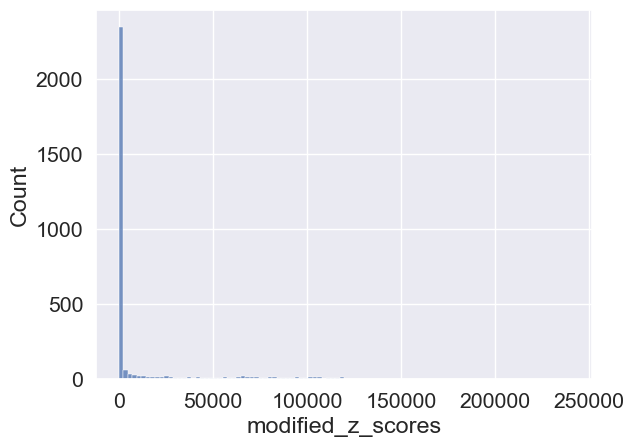

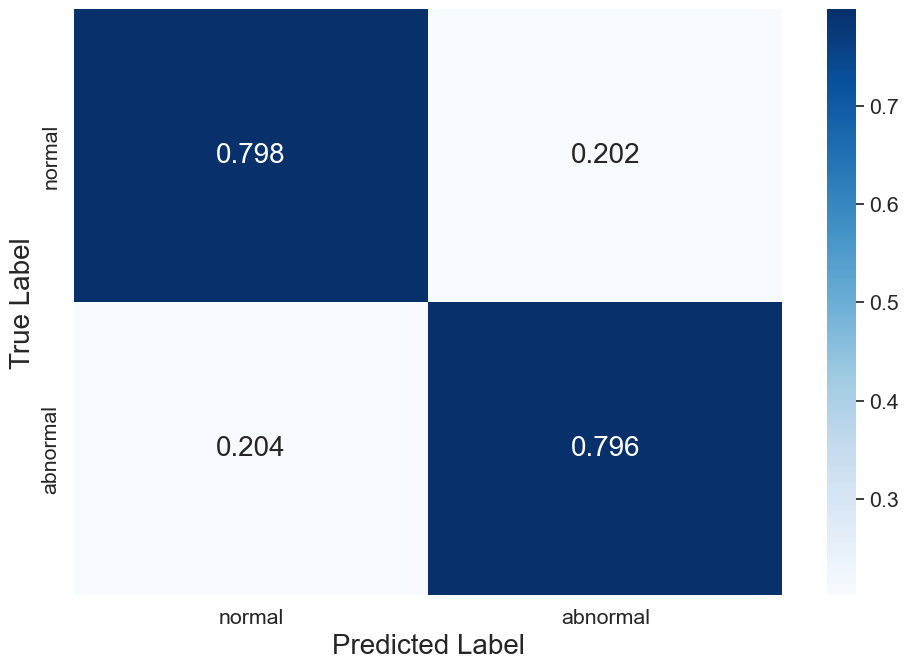

In [7]:
def calculate_metrics_modified_zscore(actual_labels, anomaly_scores, normal_anomaly_scores, z_threshold=1):
    median = np.median(normal_anomaly_scores)
    median_absolute_deviation = np.median(np.abs(normal_anomaly_scores-median))

    # Z-Score 계산
    modified_z_scores = 0.6745*(anomaly_scores - median) / median_absolute_deviation
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (np.abs(modified_z_scores) > z_threshold).astype('int')

    # print(len(actual_labels))
    # print(len(predicted_labels))
    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)


    abnormal_scores = np.array(normal_anomaly_scores)
    normal_labels = np.zeros_like(normal_anomaly_scores)

    scores = np.hstack(abnormal_scores).tolist()
    labels = np.hstack(normal_labels).tolist()



    labels = labels[:len(modified_z_scores)]
    print(len(modified_z_scores))
    target_df = pd.DataFrame({"modified_z_scores": modified_z_scores})
   
    sns.histplot(target_df, x="modified_z_scores", bins=100)
    # plt.xlim([-1,1])
    # plt.show()
    # Z-Score를 기준으로 이상 감지
    # predicted_labels = (z_scores > z_threshold).astype(int)


    return predicted_labels, z_threshold, f1
    

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)


    # plt.title(f'{sn, pad=20, fontsize=20)
    plt.tight_layout()
    plt.show()
    plt.close() 

def use_modified_zscore(test=False):

    train_csv_files = read_csv_files('./train')
    # print(train_csv_files)
    train_actual_labels, train_tot, train_normal_anomaly_scores, train_abnormal_scores = get_labels_and_scores_n(train_csv_files)

    test_csv_files = read_csv_files('./test')
    # print(sorted(train_csv_files))
    test_actual_labels, test_tot, test_normal_anomaly_scores, test_abnormal_scores = get_labels_and_scores_n(test_csv_files)
    # print(test_actual_labels)

    results = calculate_metrics_modified_zscore(test_actual_labels, test_tot, train_normal_anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1:.04}')
    
    draw_confusion_matrix(test_actual_labels, predicted_labels)
    
    # return results


use_modified_zscore(test=True)


In [8]:
def max_f1score(actual_labels, anomaly_scores):
    precision, recall, thresholds = precision_recall_curve(actual_labels, anomaly_scores)
    f1_score =  2 * (precision * recall) / (precision + recall)

    optimal_idx = np.argmax(f1_score)
    optimal_threshold = thresholds[optimal_idx]
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)

    # Precision-Recall Curve 시각화
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold}')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(f'Precision-Recall Curve', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_threshold, predicted_labels, f1_score[optimal_idx]

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        # plt.title(f'{/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        # plt.title(f'{', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.show() 

def use_max_f1(test=False):
    csv_files = read_csv_files(test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    optimal_threshold, predicted_labels, f1 = max_f1score(actual_labels, anomaly_scores) 
    
    draw_confusion_matrix(actual_labels, predicted_labels, test)
    AUPRC = average_precision_score(actual_labels, anomaly_scores)

    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1:.04}')
    print(f'Average Precision Score: {AUPRC}')

use_max_f1(test=False)


TypeError: read_csv_files() got an unexpected keyword argument 'test'